In [1]:
import numpy as np
rnd_gen = np.random.default_rng(2024)
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.integrate import quad
from online_cp.CPS import NearestNeighboursPredictionMachine
from online_cp import PluginMartingale
from ucimlrepo import fetch_ucirepo 
from scipy.stats import beta

In [2]:
def compute_CPRS(pred_dist, y_true, yrange, tau):
    # Compute CDF and normalize
    cdf_values = np.array([pred_dist(y, tau) for y in yrange])

    # Observed value
    x_obs = y_true

    # Compute CRPS
    indicator = np.where(yrange >= x_obs, 1, 0)  # Heaviside function
    differences = cdf_values - indicator
    dx = np.diff(yrange)

    crps = np.sum((differences[:-1] ** 2) * dx)

    return crps

In [3]:
# fetch dataset Concrete Compressive Strength
concrete_compressive_strength = fetch_ucirepo(id=165) 
  
# data (as pandas dataframes) 
X = concrete_compressive_strength.data.features.astype('float')
Y = concrete_compressive_strength.data.targets.astype('float')

In [4]:
N = 500
X = (X - X.mean()) / X.std()
X = X.values[:N]
Y = Y.values.flatten()[:N]

# Ensure all labels are unique
noise_range = 1e-6
while np.unique(Y).shape[0] < Y.shape[0]:
    # Find duplicates
    unique, counts = np.unique(Y, return_counts=True)
    duplicates = unique[counts > 1]

    # Add noise to duplicate entries
    for label in duplicates:
        indices = np.where(Y == label)[0]
        noise = rnd_gen.uniform(low=-noise_range, high=noise_range, size=len(indices))
        Y[indices] += noise

In [5]:
initial_training_size = 100
X_train = X[:initial_training_size]
y_train = Y[:initial_training_size]
X_test = X[initial_training_size:]
y_test = Y[initial_training_size:]

In [6]:
cps = NearestNeighboursPredictionMachine(k=31)

martingale = PluginMartingale(warnings=False, betting_function='beta_bayes')

calibration_martingale = PluginMartingale(warnings=False, betting_function='beta_bayes')

cps.learn_initial_training_set(X_train, y_train)

Base_loss = 0
Protected_loss = 0

cum_loss = np.zeros(shape=(y_test.shape[0], 2))

for i, (object, label) in tqdm(enumerate(zip(X_test, y_test)), total=y_test.shape[0], desc='Running protected CPS'):
    # Reality outputs object and a random number tau
    tau = rnd_gen.uniform(0, 1)

    # Forecaster outputs a conformal predictive distribution
    cpd, precomputed = cps.predict_cpd(x=object, return_update=True) # We return the precomputed update for later use

    # Martingale protection
    if 'beta' in martingale.betting_function:
        # Then we can avoid computing the integral, since we have a CDF
        B = lambda x: beta.cdf(x, martingale.ahat, martingale.bhat)
        protected_cpd = lambda y, tau: B(cpd(y, tau))
        b = martingale.current_betting_function # Just for reference
    else:
        b = martingale.current_betting_function
        B = lambda x: quad(b, 0, x)[0]
        protected_cpd = lambda y, tau: B(cpd(y, tau))

    # Reality outputs label
    # Compute loss
    yrange = np.linspace(cpd.Y[1:-1].min()-1, cpd.Y[1:-1].max()+1, num=100, endpoint=True)
    base_loss = compute_CPRS(cpd, label, yrange, tau)
    protected_loss = compute_CPRS(protected_cpd, label, yrange, tau)

    Base_loss += base_loss
    Protected_loss += protected_loss

    cum_loss[i, 0] = Base_loss
    cum_loss[i, 1] = Protected_loss

    # Learn new object
    cps.learn_one(x=object, y=label, precomputed=precomputed) # We pass precomputed as an argument to avoid redundant computations

    # Update martingale
    martingale.update_log_martingale(cpd(y=label, tau=tau))

    calibration_martingale.update_log_martingale(protected_cpd(y=label, tau=tau))

Running protected CPS:   0%|          | 0/400 [00:00<?, ?it/s]

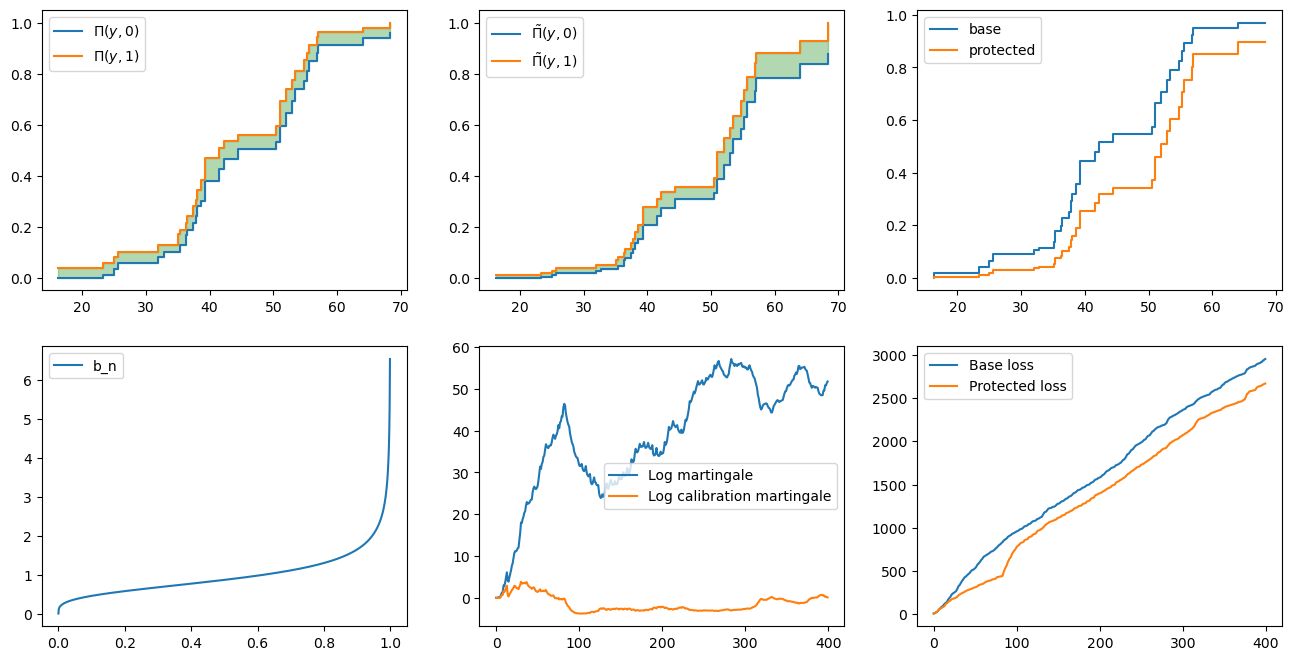

In [7]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(16,8))

axs[0, 0].step(
    cpd.Y[1:-1], 
    [cpd(y, 0) for y in cpd.Y[1:-1]], 
    where='post',
    label=r'$\Pi(y, 0)$'
)
axs[0, 0].step(
    cpd.Y[1:-1], 
    [cpd(y, 1) for y in cpd.Y[1:-1]],
    where='post',
    label=r'$\Pi(y, 1)$'
)

# Use fill_between for the area between the two step functions
axs[0, 0].fill_between(
    cpd.Y[1:-1],
    [cpd(y, 0) for y in cpd.Y[1:-1]], 
    [cpd(y, 1) for y in cpd.Y[1:-1]], 
    step='post', 
    color='green', 
    alpha=0.3, 
)
axs[0, 0].legend()


axs[0, 1].step(
    cpd.Y[1:-1], 
    [protected_cpd(y, 0) for y in cpd.Y[1:-1]],
    where='post',
    label=r'$\tilde{\Pi}(y, 0)$'
)
axs[0, 1].step(
    cpd.Y[1:-1], 
    [protected_cpd(y, 1) for y in cpd.Y[1:-1]],
    where='post',
    label=r'$\tilde{\Pi}(y, 1)$'
)
axs[0, 1].fill_between(
    cpd.Y[1:-1],
    [protected_cpd(y, 0) for y in cpd.Y[1:-1]], 
    [protected_cpd(y, 1) for y in cpd.Y[1:-1]], 
    step='post', 
    color='green', 
    alpha=0.3, 
)
axs[0, 1].legend()

axs[0, 2].step(
    cpd.Y[1:-1], 
    [cpd(y, tau) for y in cpd.Y[1:-1]], 
    label='base'
)
axs[0, 2].step(
    cpd.Y[1:-1], 
    [protected_cpd(y, tau) for y in cpd.Y[1:-1]], 
    label='protected'
)
axs[0, 2].legend()

prange = np.linspace(0, 1, num=1000)
axs[1, 0].plot(
    prange,
    [b(p) for p in prange],
    label=r'b_n'
)
axs[1, 0].legend()


axs[1, 1].plot(np.log(martingale.martingale_values), label='Log martingale')
axs[1, 1].plot(np.log(calibration_martingale.martingale_values), label='Log calibration martingale')
axs[1, 1].legend()

axs[1, 2].plot(cum_loss, label=['Base loss', 'Protected loss'])
axs[1, 2].legend()

In [8]:
print(f'CRPS Loss CPS: {Base_loss}')
print(f'CRPS Loss protected CPS: {Protected_loss}')
print(f'CRPS Improvement: {1 - Protected_loss / Base_loss}')

CRPS Loss CPS: 2952.624077429533
CRPS Loss protected CPS: 2668.805600419249
CRPS Improvement: 0.09612414908482625
